# 光流

在本章中，
- 我们将了解光流的概念及其使用Lucas-Kanade方法的估计。
- 我们将使用**cv.calcOpticalFlowPyrLK**()之类的函数来跟踪视频中的特征点。
- 我们将使用**cv.calcOpticalFlowFarneback**()方法创建一个密集的光流场。

### 光流

光流是由物体或照相机的运动引起的两个连续帧之间图像物体的视运动的模式。它是2D向量场，其中每个向量都是位移向量，表示点从第一帧到第二帧的运动。考虑下面的图片（图片提供：Wikipedia关于Optical Flow的文章）。

![](data/optical_flow_basic1.jpg)

它显示了一个球连续5帧运动。箭头显示其位移向量。光流在以下领域具有许多应用：
- 运动的结构
- 视频压缩
- 视频稳定...

光流基于以下几个假设进行工作：
1. 在连续的帧之间，对象的像素强度不变。
2. 相邻像素具有相似的运动。

考虑第一帧中的像素$I(x,y,t)$（在此处添加新维度：时间。之前我们只处理图像，因此不需要时间）。它在$dt$时间之后拍摄的下一帧中按距离$(dx，dy)$移动。因此，由于这些像素相同且强度不变，因此可以说

$$
I(x,y,t) = I(x+dx, y+dy, t+dt)
$$

然后采用泰勒级数的右侧逼近，去掉常用项并除以$dt$得到下面的式子

$$
f_x u + f_y v + f_t = 0 \;
$$

其中
$$
f_x = \frac{\partial f}{\partial x} \; ; \; f_y = \frac{\partial f}{\partial y}
$$

$$
u = \frac{dx}{dt} \; ; \; v = \frac{dy}{dt}
$$

上述方程式称为光流方程式。在其中，我们可以找到$f_x$和$f_y$，它们是图像渐变。同样，$f_t$是随时间变化的梯度。但是$(u，v)$是未知的。我们不能用两个未知变量来求解这个方程。因此，提供了几种解决此问题的方法，其中一种是Lucas-Kanade。

#### Lucas-Kanade 方法

之前我们已经看到一个假设，即所有相邻像素将具有相似的运动。Lucas-Kanade方法在该点周围需要3x3色块。因此，所有9个点都具有相同的运动。我们可以找到这9点的$(fx,fy,ft)$。所以现在我们的问题变成了求解带有两个未知变量的9个方程组的问题。用最小二乘拟合法可获得更好的解决方案。下面是最终的解决方案，它是两个方程式-两个未知变量问题，求解以获得解决答案。

$$
\begin{bmatrix} u \\ v \end{bmatrix} = \begin{bmatrix} \sum_{i}{f_{x_i}}^2 & \sum_{i}{f_{x_i} f_{y_i} } \\ \sum_{i}{f_{x_i} f_{y_i}} & \sum_{i}{f_{y_i}}^2 \end{bmatrix}^{-1} \begin{bmatrix} - \sum_{i}{f_{x_i} f_{t_i}} \\ - \sum_{i}{f_{y_i} f_{t_i}} \end{bmatrix}
$$

（用哈里斯拐角检测器检查逆矩阵的相似性。这表示拐角是更好的跟踪点。）因此，从用户的角度来看，这个想法很简单，我们给一些跟踪点，我们接收到这些光流矢量点。但是同样存在一些问题。到现在为止，我们只处理小动作，所以当大动作时它就失败了。为了解决这个问题，我们使用金字塔。当我们上金字塔时，较小的动作将被删除，较大的动作将变为较小的动作。因此，通过在此处应用Lucas-Kanade，我们可以获得与尺度一致的光流。

### OpenCV中的Lucas-Kanade

OpenCV在单个函数**cv.calcOpticalFlowPyrLK**()中提供所有这些功能。在这里，我们创建一个简单的应用程序来跟踪视频中的某些点。为了确定点，我们使用**cv.goodFeaturesToTrack**()。我们采用第一帧，检测其中的一些Shi-Tomasi角点，然后使用Lucas-Kanade光流迭代地跟踪这些点。对于函数**cv.calcOpticalFlowPyrLK**()，我们传递前一帧，前一点和下一帧。它返回下一个点以及一些状态码，如果找到下一个点，状态码的值为1，否则为零。我们将这些下一个点迭代地传递为下一步中的上一个点。请参见下面的代码：

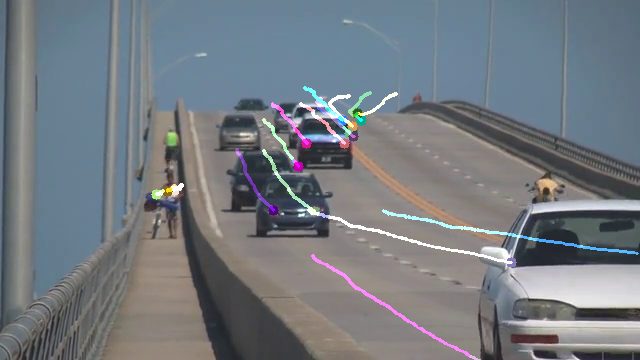

In [1]:
import numpy as np
import cv2 as cv
from IPython.display import clear_output, display, HTML
from PIL import Image
import time

cap = cv.VideoCapture('data/slow_traffic_small.mp4')


# 用于ShiTomasi拐点检测的参数
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# lucas kanade光流参数
lk_params = dict( winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 0.03))

# 创建一些随机的颜色
color = np.random.randint(0,255,(100,3))

# 拍摄第一帧并在其中找到拐角
ret, old_frame = cap.read()
old_gray = cv.cvtColor(old_frame, cv.COLOR_BGR2GRAY)
p0 = cv.goodFeaturesToTrack(old_gray, mask = None, **feature_params)

# 创建用于作图的掩码图像
mask = np.zeros_like(old_frame)

while(1):
    clear_output(wait=True)

    ret,frame = cap.read()

    frame_gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

    # 计算光流
    p1, st, err = cv.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # 选择良好点
    good_new = p1[st==1]
    good_old = p0[st==1]

    # 绘制跟踪
    for i,(new,old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv.circle(frame,(a,b),5,color[i].tolist(),-1)

    img = cv.add(frame,mask)

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = Image.fromarray(img)

    display(img)

    if cap.get(cv.CAP_PROP_POS_FRAMES) > 160:
        break

    # 控制帧率
    time.sleep(0.033)
    
    # 现在更新之前的帧和点
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)

cap.release()

（此代码不会检查下一个关键点的正确性。因此，即使任何特征点在图像中消失了，光流也有可能找到下一个看起来可能与它接近的下一个点。因此，对于稳健的跟踪，实际上 应该以特定的时间间隔检测点。OpenCV样本附带了这样一个样本，该样本每5帧发现一次特征点，并且还对光流点进行了后向检查，以仅选择良好的流点。请参阅代码 samples/python/lk_track.py）。

### OpenCV中的密集光流

Lucas-Kanade方法计算稀疏特征集的光流（在我们的示例中为使用Shi-Tomasi算法检测到的角）。OpenCV提供了另一种算法来查找密集的光流。它计算帧中所有点的光通量。它基于Gunner Farneback的算法，在2003年Gunner Farneback的“基于多项式展开的两帧运动估计”中对此进行了解释。

下面的示例显示了如何使用上述算法找到密集的光流。我们得到一个带有光流矢量$(u,v)$的2通道阵列。我们找到了它们的大小和方向。我们对结果进行颜色编码，以实现更好的可视化。方向对应于图像的色相值。幅度对应于值平面。请参见下面的代码： 

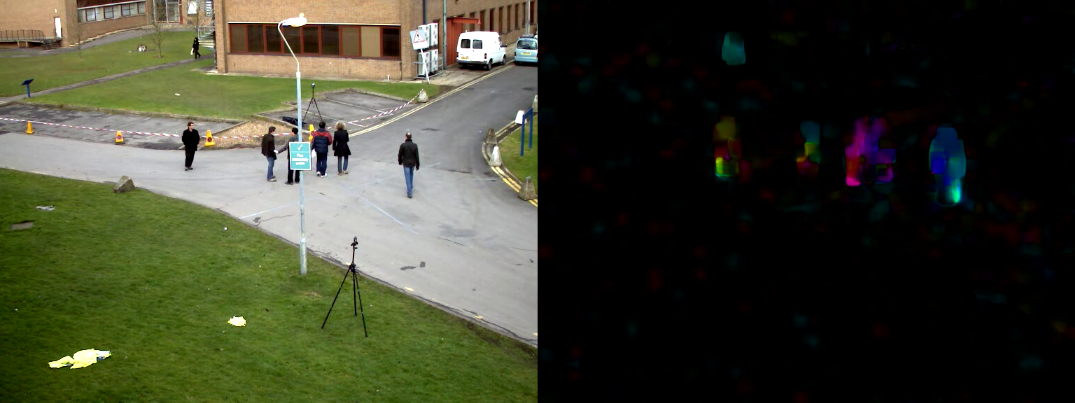

In [2]:
import numpy as np
import cv2 as cv
from IPython.display import clear_output, display, HTML
from PIL import Image
import time

cap = cv.VideoCapture('data/vtest.avi')

ret, frame1 = cap.read()

prvs = cv.cvtColor(frame1,cv.COLOR_BGR2GRAY)
hsv = np.zeros_like(frame1)
hsv[...,1] = 255

while(1):
    clear_output(wait=True)

    ret, frame2 = cap.read()

    next = cv.cvtColor(frame2,cv.COLOR_BGR2GRAY)
    flow = cv.calcOpticalFlowFarneback(prvs,next, None, 0.5, 3, 15, 3, 5, 1.2, 0)

    mag, ang = cv.cartToPolar(flow[...,0], flow[...,1])

    hsv[...,0] = ang*180/np.pi/2
    hsv[...,2] = cv.normalize(mag,None,0,255,cv.NORM_MINMAX)

    bgr = cv.cvtColor(hsv,cv.COLOR_HSV2BGR)

    #展示当前帧和背景掩码
    res = np.hstack((frame2, bgr))
    res = cv.resize(res, None, fx=0.7, fy = 0.7)
    
    res = cv.cvtColor(res, cv.COLOR_BGR2RGB)
    img = Image.fromarray(res)

    display(img)

    if cap.get(cv.CAP_PROP_POS_FRAMES) > 80:
        break

    # 控制帧率
    time.sleep(0.1)
    
    prvs = next

cap.release()